## Homework 2

Using Python for Excel type tasks

## Import some libraries

In [48]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import commonly used libraries and magic command for inline plotting

In [49]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [50]:
%matplotlib inline

Now I am going to import 'Model' and 'get_sim_results_df' from the provided whatif.py file

In [51]:
from whatif import Model
from whatif import get_sim_results_df

# Analysis 1 – Basic Break Even Analysis

The owner of a relatively small business is trying to determine the breakeven level of sales of the company’s single product.  The fixed cost of manufacturing this product each month is \\$60,000.00.  The variable cost of producing this product is \\$90 per unit.  The current selling price is \\$120.  Using historical data on selling price and monthly demand, the owner fit the following function relating demand and selling price:

Selling Price Function (SPF)
D=10,000,000S^(-1.8)

where D is the monthly demand for the product and S is the selling price.  The form of this function is called a power function. So, if we increase our selling price, we believe demand will decrease. Similarly, a decrease in selling price suggests an increase in demand. Let’s call this equation the Selling Price Function (or SPF, for short).



## Base Model
Create a Python based model to that relates profit to the inputs. It must be an object oriented model. Here's the start of our class definition code:

Based on the initial information given above, our variables can be defined as follows:

In [52]:
# Set the base inputs
fixed_cost = 60000
var_cost = 90
selling_price = 120
spf_scale = 10000000
spf_exponent = -1.8

Here's the start of our class definition code:

In [53]:
class SingleProductSPF(Model):
    def __init__(self, fixed_cost, var_cost, selling_price,
                spf_scale, spf_exponent):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_scale = spf_scale
        self.spf_exponent = spf_exponent
        

In [54]:
# Create a new SingleProductSPFModel object
model_1 = SingleProductSPF(fixed_cost, var_cost, selling_price, spf_scale, spf_exponent)

Let's try printing out one of the model properties to make sure we are on track...

In [55]:
print(model_1.fixed_cost)

60000


So far, so good.  Now I am going to add some methods to my model that compute profit and demand

In [56]:
class SingleProductSPF(Model):
    def __init__(self, fixed_cost, var_cost, selling_price,
                spf_scale, spf_exponent):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_scale = spf_scale
        self.spf_exponent = spf_exponent
        
    def demand(self):
        """Compute demand"""
        return self.spf_scale * (self.selling_price ** self.spf_exponent)
    
    def revenue(self):
        """Compute revenue"""
        return self.demand() * self.selling_price
    
    def costs(self):
        """Compute total of fixed and variable costs"""
        return (self.demand() * self.var_cost) + self.fixed_cost   
    
    def profit(self):
        """Compute profit"""
        return self.revenue() - self.costs()
    
    def __str__(self):
        """
        String representation of SingleProductSPF's inputs
        """
        return str(vars(self))

        

I'm going to create a new object instance based on the updated class definition.

In [57]:
model_2 = SingleProductSPF(fixed_cost, var_cost, selling_price, spf_scale, spf_exponent)

In [58]:
print(model_2.demand())
print(model_2.profit())

1809.146586595383
-5725.602402138524


Ok, so far, so good.  Although I have to admit I was a little stumped by needing those ()'s for the methods and not for the properties.

We can also remind ourself of the properties used with the following:

In [59]:
print(model_2)

{'fixed_cost': 60000, 'var_cost': 90, 'selling_price': 120, 'spf_scale': 10000000, 'spf_exponent': -1.8}


## 1-Way Data Table
Create a one-way data table using our data_table function to show how profit and demand are related to selling price.

Profit and demand are the outputs and selling price is the input. Let price range from 90 to 190 in steps of 10.

In [60]:
# Set property equal to an array
model_2.selling_price = np.arange(90, 191, 10)
model_2.selling_price

array([ 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190])

We can compute an array of profits...

In [61]:
model_2.profit()

array([-60000.        , -34881.1356849 , -17682.19213811,  -5725.60240214,
         2655.89776817,   8539.28035168,  12641.86473138,  15453.96586116,
        17318.23446585,  18478.73612485,  19112.2102885 ])

We can use the data_table function to create a dataframe of profit outputs for every selling_price input

We can also call up this function from whatif.py, as it was built in as part of our model

Following I have done both...  (just for good practice)

In [62]:
from sklearn.model_selection._search import ParameterGrid

In [63]:
def data_table(model, scenario_inputs, outputs):
    '''Create n-inputs by m-outputs data table. 

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for computing outputs from inputs
    scenario_inputs : dict of str to sequence
        Keys are input variable names and values are sequence of values for each scenario for this variable.
    outputs : list of str
        List of output variable names

    Returns
    -------
    results_df : pandas DataFrame
        Contains values of all outputs for every combination of scenario inputs
    '''

    # Clone the model using deepcopy
    model_clone = copy.deepcopy(model)
    
    # Create parameter grid
    dt_param_grid = list(ParameterGrid(scenario_inputs))
    
    # Create the table as a list of dictionaries
    results = []

    # Loop over the scenarios
    for params in dt_param_grid:
        # Update the model clone with scenario specific values
        model_clone.update(params)
        # Create a result dictionary based on a copy of the scenario inputs
        result = copy.copy(params)
        # Loop over the list of requested outputs
        for output in outputs:
            # Compute the output.
            out_val = getattr(model_clone, output)()
            # Add the output to the result dictionary
            result[output] = out_val
        
        # Append the result dictionary to the results list
        results.append(result)

    # Convert the results list (of dictionaries) to a pandas DataFrame and return it
    results_df = pd.DataFrame(results)
    return results_df

In [64]:
# Specify input ranges for scenarios (dictionary)
# 1-way table
dt_param_ranges_1 = {'selling_price': np.arange(90, 191, 10)}

# Specify desired outputs (list)
outputs = ['demand', 'profit']

# Use data_table function to create 1-way data table
m2_dt1_df = data_table(model_2, dt_param_ranges_1, outputs)
m2_dt1_df

,selling_price,demand,profit
0,90,3036.431464,-60000.000000
1,100,2511.886432,-34881.135685
2,110,2115.890393,-17682.192138
3,120,1809.146587,-5725.602402
4,130,1566.397444,2655.897768
5,140,1370.785607,8539.280352
6,150,1210.697746,12641.864731
7,160,1077.913798,15453.965861
8,170,966.477931,17318.234466
9,180,871.985957,18478.736125


In [65]:
# Use data_table function built into our 'Model' to create 1-way data table
m2_dt1_df2 = model_2.data_table(dt_param_ranges_1, outputs)
m2_dt1_df2

,selling_price,demand,profit
0,90,3036.431464,-60000.000000
1,100,2511.886432,-34881.135685
2,110,2115.890393,-17682.192138
3,120,1809.146587,-5725.602402
4,130,1566.397444,2655.897768
5,140,1370.785607,8539.280352
6,150,1210.697746,12641.864731
7,160,1077.913798,15453.965861
8,170,966.477931,17318.234466
9,180,871.985957,18478.736125


### Graph Demand and Profit
Create a graph based on your data table object so that it is easy to visualize the relationship between selling price and profit

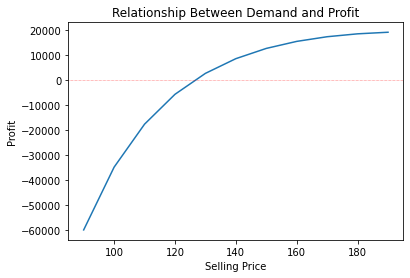

In [66]:
x = model_2.selling_price
y = model_2.profit()
plt.plot(x, y)
plt.title('Relationship Between Demand and Profit')
plt.xlabel('Selling Price')
plt.ylabel('Profit')
plt.axhline(linewidth=.5, color='r', linestyle='dotted')
plt.show()

### Discuss the shape of this relationship. Is it linear? Is it nonlinear? Why do you think the graph has the shape it does?

The relationship is not linear.  Profit (Loss) increases with a positive slope as the selling price increases.  This seems to level off around \\$180.  After that point the gain in profit seems to be minimal, as the slope of the line is flattening. 


The graph has a significant positive slope while profit is in negative territory, as each increase in the selling price helps to cover the fixed costs.  Once you reach the breakeven point (around \\$127ish) the slope starts to decrease.  Once fixed costs are covered, profit is a direct result of the price v. demand.  As the selling price increases the demand will die off which accounts for the flattening of the curve.

## Break Even
Use our goal_seek function to find the break even selling price. 

We'll create another fresh model for our goal seek

In [67]:
# Create a dictionary of base inputs
base_inputs = {'fixed_cost': 60000,
               'var_cost': 90,
               'selling_price': 120,
               'spf_scale': 10000000,
               'spf_exponent': -1.8}

In [81]:
# Create a new model with inputs specified by base_inputs dict
model_3 = SingleProductSPF(**base_inputs)
print(model_3)
model_3.profit()

{'fixed_cost': 60000, 'var_cost': 90, 'selling_price': 120, 'spf_scale': 10000000, 'spf_exponent': -1.8}


-5725.602402138524

Here is our goal seek function:

In [69]:
def goal_seek(model, obj_fn, target, by_changing, a, b, N=100, verbose=False):
    '''Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for doing the desired goal seek
    obj_fn : function
        The function for which we are trying to approximate a solution f(x)=target.
    target : float
        The goal
    by_changing : string
        Name of the input variable in model
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if (f(a) - target) * (f(b) - target) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.
    verbose : boolean (default=False)
        If True, root finding progress is reported

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) - target == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.
    '''
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # The following bisection search is a direct adaptation of
    # https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/bisection/
    # The changes include needing to use an object method instead of a global function
    # and the inclusion of a non-zero target value.
    
    setattr(model_clone, by_changing, a)
    f_a_0 = getattr(model_clone, obj_fn)()
    setattr(model_clone, by_changing, b)
    f_b_0 = getattr(model_clone, obj_fn)()
    
    if (f_a_0 - target) * (f_b_0 - target) >= 0:
        # print("Bisection method fails.")
        return None
    
    # Initialize the end points
    a_n = a
    b_n = b
    for n in range(1, N+1):
        # Compute the midpoint
        m_n = (a_n + b_n)/2
        
        # Function value at midpoint
        setattr(model_clone, by_changing, m_n)
        f_m_n = getattr(model_clone, obj_fn)()
        
        # Function value at a_n
        setattr(model_clone, by_changing, a_n)
        f_a_n = getattr(model_clone, obj_fn)()
        
        # Function value at b_n
        setattr(model_clone, by_changing, b_n)
        f_b_n = getattr(model_clone, obj_fn)()
        
        if verbose:
            print(f"n = {n}, a_n = {a_n}, b_n = {b_n}, m_n = {m_n}, width = {b_n - a_n}")

        # Figure out which half the root is in, or if we hit it exactly, or if the search failed
        if (f_a_n - target) * (f_m_n - target) < 0:
            a_n = a_n
            b_n = m_n
            if verbose:
                print("Root is in left half")
        elif (f_b_n - target) * (f_m_n - target) < 0:
            a_n = m_n
            b_n = b_n
            if verbose:
                print("Root is in right half")
        elif f_m_n == target:
            if verbose:
                print("Found exact solution.")
            return m_n
        else:
            if verbose:
                print("Bisection method fails.")
            return None
    
    # If we get here we hit iteration limit, return best solution found so far
    if verbose:
        print("Reached iteration limit")
    return (a_n + b_n)/2

... and now we will use it to find our break even point

In [70]:
goal_seek(model_3, 'profit', 0, 'selling_price', 100, 200, N=100, verbose=True)

n = 1, a_n = 100, b_n = 200, m_n = 150.0, width = 100
Root is in left half
n = 2, a_n = 100, b_n = 150.0, m_n = 125.0, width = 50.0
Root is in right half
n = 3, a_n = 125.0, b_n = 150.0, m_n = 137.5, width = 25.0
Root is in left half
n = 4, a_n = 125.0, b_n = 137.5, m_n = 131.25, width = 12.5
Root is in left half
n = 5, a_n = 125.0, b_n = 131.25, m_n = 128.125, width = 6.25
Root is in left half
n = 6, a_n = 125.0, b_n = 128.125, m_n = 126.5625, width = 3.125
Root is in left half
n = 7, a_n = 125.0, b_n = 126.5625, m_n = 125.78125, width = 1.5625
Root is in right half
n = 8, a_n = 125.78125, b_n = 126.5625, m_n = 126.171875, width = 0.78125
Root is in right half
n = 9, a_n = 126.171875, b_n = 126.5625, m_n = 126.3671875, width = 0.390625
Root is in right half
n = 10, a_n = 126.3671875, b_n = 126.5625, m_n = 126.46484375, width = 0.1953125
Root is in left half
n = 11, a_n = 126.3671875, b_n = 126.46484375, m_n = 126.416015625, width = 0.09765625
Root is in right half
n = 12, a_n = 126.41

126.43389135922071

Instead of bringing the function into this notebook, we can also use the goal_seek that is tucked into our 'Model'...

Easier, but I wanted to see the verbose output for fun ;)

In [71]:
model_3.goal_seek('profit', 0, 'selling_price', 100, 200)

126.43389135922071

The break even selling price is \\$126.43, which is exactly where we expected it to be based on the plotting we did previously

## 2-Way Data Table
Create a 2-way data table using data_table for profit AND total cost. Let price range from \\$90 to \\$190 in steps of \\$10 and let the variable production cost vary from \\$85 to \\$110 in steps of \\$5.

In [72]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges_2 = {'selling_price': np.arange(90, 191, 10),
                   'var_cost': np.arange(85, 111, 5)}

# Specify desired outputs (list)
outputs_2 = ['demand', 'profit']

# Use data_table function built into our 'Model' to create 2-way data table
m2_dt2way_df = model_2.data_table(dt_param_ranges_2, outputs_2)
m2_dt2way_df

,selling_price,var_cost,demand,profit
0,90,85,3036.431464,-44817.842680
1,90,90,3036.431464,-60000.000000
2,90,95,3036.431464,-75182.157320
3,90,100,3036.431464,-90364.314640
4,90,105,3036.431464,-105546.471960
...,...,...,...,...
61,190,90,791.122103,19112.210288
62,190,95,791.122103,15156.599774
63,190,100,791.122103,11200.989260
64,190,105,791.122103,7245.378745


## Simulation
Add some uncertainty to the SPF exponent. Specifically, model it with a uniform distribution between (-1.6, -2.0)

In [73]:
from numpy.random import default_rng
rg = default_rng(4470)
rg.random() # Generate one just to see it work

0.45855804438027437

Generate 1000 random variates from a uniform distribution 

In [74]:
spf_exp_sim = rg.uniform(-2.0, -1.6, 1000)

In [75]:
spf_exp_sim[:10]

array([-1.93991299, -1.91525292, -1.86294876, -1.62626725, -1.71525073,
       -1.71226064, -1.75090368, -1.84660017, -1.97019406, -1.97731118])

Looks good so far

We can plot it to confirm we will get a uniform distribution...

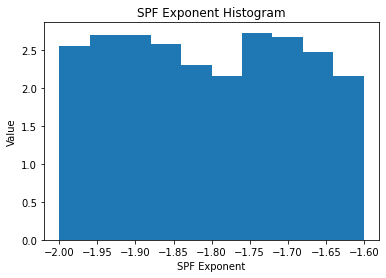

In [76]:
plt.title("SPF Exponent Histogram")
plt.xlabel("SPF Exponent")
plt.ylabel("Value")
plt.hist(spf_exp_sim, density=True);


I'm going to quickly make a new model to do our simulation on... same vaues we have used before

In [77]:
# Create a new model with same inputs specified by base_inputs dict above
model_4 = SingleProductSPF(**base_inputs)
print(model_4)

{'fixed_cost': 60000, 'var_cost': 90, 'selling_price': 120, 'spf_scale': 10000000, 'spf_exponent': -1.8}


I'm going to only do 100 reps for this scenario...

In [78]:
num_reps = 100
spf_exp_sim2 = rg.uniform(-2.0, -1.6, num_reps)

random_inputs = {'spf_exponent': spf_exp_sim2}

In [79]:
scenario_inputs = {'selling_price': np.arange(90, 191, 10),
                   'var_cost': np.arange(85, 111, 5)}
list(ParameterGrid(scenario_inputs))

[{'selling_price': 90, 'var_cost': 85},
 {'selling_price': 90, 'var_cost': 90},
 {'selling_price': 90, 'var_cost': 95},
 {'selling_price': 90, 'var_cost': 100},
 {'selling_price': 90, 'var_cost': 105},
 {'selling_price': 90, 'var_cost': 110},
 {'selling_price': 100, 'var_cost': 85},
 {'selling_price': 100, 'var_cost': 90},
 {'selling_price': 100, 'var_cost': 95},
 {'selling_price': 100, 'var_cost': 100},
 {'selling_price': 100, 'var_cost': 105},
 {'selling_price': 100, 'var_cost': 110},
 {'selling_price': 110, 'var_cost': 85},
 {'selling_price': 110, 'var_cost': 90},
 {'selling_price': 110, 'var_cost': 95},
 {'selling_price': 110, 'var_cost': 100},
 {'selling_price': 110, 'var_cost': 105},
 {'selling_price': 110, 'var_cost': 110},
 {'selling_price': 120, 'var_cost': 85},
 {'selling_price': 120, 'var_cost': 90},
 {'selling_price': 120, 'var_cost': 95},
 {'selling_price': 120, 'var_cost': 100},
 {'selling_price': 120, 'var_cost': 105},
 {'selling_price': 120, 'var_cost': 110},
 {'selling

The question is asking for profit

In [80]:
sim_outputs = ['profit']

Simulate function taken from what_if_simulation.ipynb:

In [83]:
def simulate(model, random_inputs, outputs, scenario_inputs=None, keep_random_inputs=False):
    '''Simulate model for one or more scenarios

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for computing outputs from inputs
    random_intputs : dict of str to sequence of random variates
        Keys are stochastic input variable names and values are sequence of $n$ random variates, where $n$ is the number of simulation replications
    outputs : list of str
        List of output variable names
    scenario_inputs : optional (default is None), dict of str to sequence
        Keys are deterministic input variable names and values are sequence of values for each scenario for this variable. Is consumed by
        scikit-learn ParameterGrid() function. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
    keep_random_inputs : optional (default is False), boolean
        If True, all the random input variates are included in the results dataframe

    Returns
    -------
    results_df : list of dict
        Values of all outputs for each simulation replication. If `scenario_inputs` is not None, then this is also for every combination of scenario inputs
    '''
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # Update clone with random_inputs
    model_clone.update(random_inputs)
    
    # Store raw simulation input values if desired
    if keep_random_inputs:
        scenario_base_vals = vars(model_clone)
    else:
        scenario_base_vals = vars(model)
    
    # Initialize output counters and containers
    scenario_num = 0
    scenario_results = []
    
    # Check if multiple scenarios
    if scenario_inputs is not None:
        # Create parameter grid for scenario inputs
        sim_param_grid = list(ParameterGrid(scenario_inputs))
        
        # Scenario loop
        for params in sim_param_grid:
            model_clone.update(params)
            # Initialize scenario related outputs
            result = {}
            scenario_vals = copy.copy(params)
            result['scenario_base_vals'] = scenario_base_vals
            result['scenario_num'] = scenario_num
            result['scenario_vals'] = scenario_vals
            raw_output = {}
            
            # Output measure loop
            for output_name in outputs:
                output_array = getattr(model_clone, output_name)()
                raw_output[output_name] = output_array
            
            # Gather results for this scenario
            result['output'] = raw_output
            scenario_results.append(result)
            scenario_num += 1
                
        return scenario_results

    else:
        # Similar logic to above, but only a single scenario
        results = []
        result = {}

        result['scenario_base_vals'] = scenario_base_vals
        result['scenario_num'] = scenario_num
        result['scenario_vals'] = {}
        
        raw_output = {}
        for output_name in outputs:
            output_array = getattr(model_clone, output_name)()
            raw_output[output_name] = output_array
            
        result['output'] = raw_output  
        results.append(result)

        return results

In [85]:
model_4_sim_results = simulate(model_4, random_inputs, sim_outputs, scenario_inputs)

 Like you did, I plucked out one scenario near the middle of the selling price values and explored the outputs.

In [86]:
which_scenario = 4

# What are the keys in the output dictionaries
model_4_sim_results[which_scenario].keys()

dict_keys(['scenario_base_vals', 'scenario_num', 'scenario_vals', 'output'])

In [87]:
model_4_sim_results[which_scenario]['scenario_vals']

{'selling_price': 90, 'var_cost': 105}

In [88]:
for scenario in model_4_sim_results:
    print(scenario['scenario_num'], scenario['scenario_vals'], scenario['output']['profit'].mean())

0 {'selling_price': 90, 'var_cost': 85} -43187.23804572121
1 {'selling_price': 90, 'var_cost': 90} -60000.0
2 {'selling_price': 90, 'var_cost': 95} -76812.7619542788
3 {'selling_price': 90, 'var_cost': 100} -93625.52390855759
4 {'selling_price': 90, 'var_cost': 105} -110438.28586283639
5 {'selling_price': 90, 'var_cost': 110} -127251.04781711519
6 {'selling_price': 100, 'var_cost': 85} -18050.186090937266
7 {'selling_price': 100, 'var_cost': 90} -32033.457393958182
8 {'selling_price': 100, 'var_cost': 95} -46016.72869697908
9 {'selling_price': 100, 'var_cost': 100} -60000.0
10 {'selling_price': 100, 'var_cost': 105} -73983.27130302093
11 {'selling_price': 100, 'var_cost': 110} -87966.54260604182
12 {'selling_price': 110, 'var_cost': 85} -812.4492448498928
13 {'selling_price': 110, 'var_cost': 90} -12649.959395879914
14 {'selling_price': 110, 'var_cost': 95} -24487.46954690994
15 {'selling_price': 110, 'var_cost': 100} -36324.979697939954
16 {'selling_price': 110, 'var_cost': 105} -4816

We can gather results function to turn results object into an analysis ready DataFrame.

In [89]:
def get_sim_results_df(results):
    
    dfs = []    
    for r in results:
        df = pd.DataFrame(r['output'])
        df['scenario_num'] = r['scenario_num']
        for key, val in r['scenario_vals'].items():
            df[key] = val
            
        dfs.append(df)

    results_df = pd.concat(dfs)
    
    return results_df

In [91]:
model_4_sim_results_df = get_sim_results_df(model_4_sim_results)

### Histogram of Simulation
Using the data frame created above we can create various histograms of profit

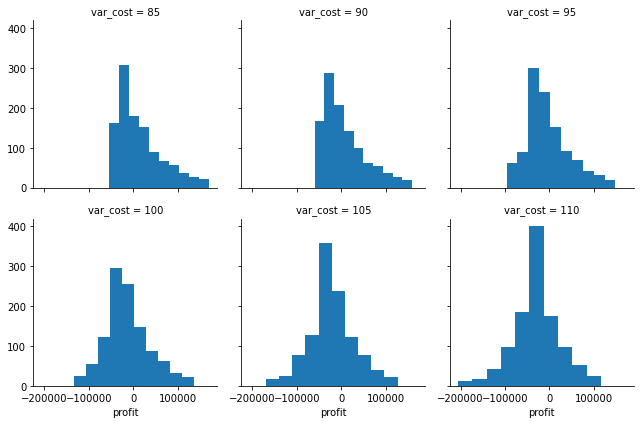

In [93]:
# Histogram faceted by variable cost
profit_histo = sns.FacetGrid(model_4_sim_results_df, col='var_cost', sharey=True, col_wrap=3)
profit_histo = profit_histo.map(plt.hist, "profit")

Not surprisingly as the variable costs rise the likelihood of making a profit falls

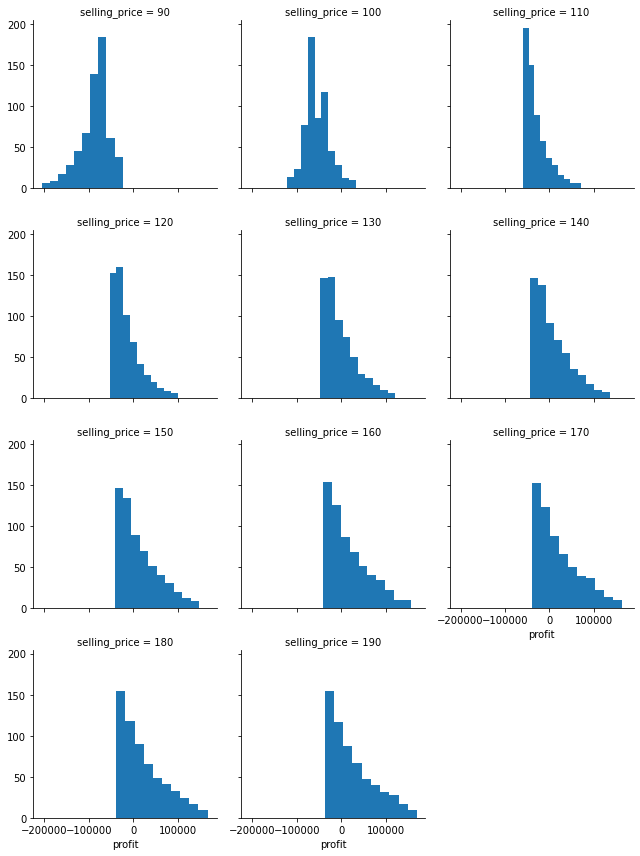

In [94]:
# Histogram faceted by selling price
profit_histo = sns.FacetGrid(model_4_sim_results_df, col='selling_price', sharey=True, col_wrap=3)
profit_histo = profit_histo.map(plt.hist, "profit")

... and also as expected the likelihood of making a profit increases with selling price... to a point, at which time demand decreases and profit along with it

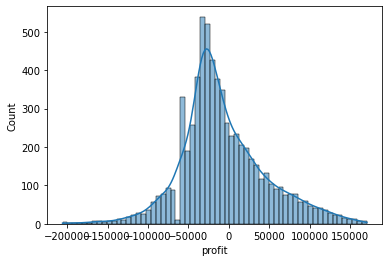

In [96]:
# Histogram showing only profit
sns.histplot(model_4_sim_results_df, x="profit", kde=True)
plt.show()

### What is the probability that profit is negative based on our simulation?

In [98]:
from scipy import stats

In [102]:
# Probability that profit is negative

print(stats.percentileofscore(model_4_sim_results_df.profit, 0) / 100.0)

0.6368181818181818


The probability of profit being less than zero, allowing for a random spf exponent (within the range of -1.6 to -2.0), and also allowing for various scenarios with regard to the selling price and variable costs is 63.68\%

Yikes!

# Analysis 2 – Extended Break Even Analysis

## Capacity Issues
Create a new model class to take the following complication into account. 

If PredictedDemand (from the SPF) is greater than 1000 but less than or equal to 1200 we have to use overtime to be able to meet demand. In this case, we decide to model this by increasing the unit production cost from \\$90 to \\$110 for all units of demand above 1000 and less than or equal to 1200. So, if demand is equal to 1050, we pay \\$90 unit production cost on the first 1000 units and pay \\$110 on the last 50 units. If demand is greater than 1200, we can only satisfy demand for 1200 units and we simply lose all the demand above that. Of course, we have to pay the overtime costs for all those above 1000 and less than or equal to 1200, as just described

Here’s the class declaration for my extended model:

In [ ]:
class SingleProductSPF_extended(Model):
    def __init__(self, fixed_cost, var_cost, selling_price,
                spf_scale, spf_exponent, ot_threshold, ot_var_cost, lost_demand_threshold):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_scale = spf_scale
        self.spf_exponent = spf_exponent
        self.ot_threshold = ot_threshold
        self.ot_var_cost = ot_var_cost
        self.lost_demand_threshold = lost_demand_threshold
        
    def demand(self):
        """Compute demand"""
        return self.spf_scale * (self.selling_price ** self.spf_exponent)
    
    def revenue(self):
        """Compute revenue"""
        return self.demand() * self.selling_price
    
    def costs(self):
        """Compute total of fixed and variable costs"""
        return (self.demand() * self.var_cost) + self.fixed_cost   
    
    def profit(self):
        """Compute profit"""
        return self.revenue() - self.costs()
    
    def __str__(self):
        """
        String representation of SingleProductSPF's inputs
        """
        return str(vars(self))